# Fitting to AP and calcium transient

The previous tutorial showed how to fit to an action potential (AP) trace.
In this tutorial, we expand this to fit to both an AP and a calcium transient (CaT).

## Fitting to an AP and CaT

As before, we start by creating an implementation of `pints.ForwardModel` that wraps around a `myokit.Simulation`:

In [2]:
import numpy as np
import pints
import myokit
import matplotlib.pyplot as plt


class APCaTModel(pints.ForwardModel):
    """
    This is a pints model, i.e. a statistical model that takes parameters and
    times as input, and returns simulated values.
    """
    def __init__(self):
        m, p, _ = myokit.load('resources/beeler-1977.mmt')
        self.simulation = myokit.Simulation(m, p)

    def n_parameters(self):
        return 5

    def n_outputs(self):
        return 2

    def simulate(self, parameters, times):

        self.simulation.reset()
        self.simulation.set_constant('ina.gNaBar', parameters[0])
        self.simulation.set_constant('ina.gNaC', parameters[1])
        self.simulation.set_constant('isi.gsBar', parameters[2])
        self.simulation.set_constant('ik1.gK1', parameters[3])
        self.simulation.set_constant('ix1.gx1', parameters[4])

        log = self.simulation.run(
            times[-1] + 1,
            log_times = times,
            log = ['membrane.V', 'calcium.Cai'],
        )
        return np.vstack((log['membrane.V'], log['calcium.Cai'])).T


Note that this model implements the extra method `n_outputs`, to override the default setting of `1`.

As before, we generate some synthetic data, but this time the generated data will be 2-dimensional array:

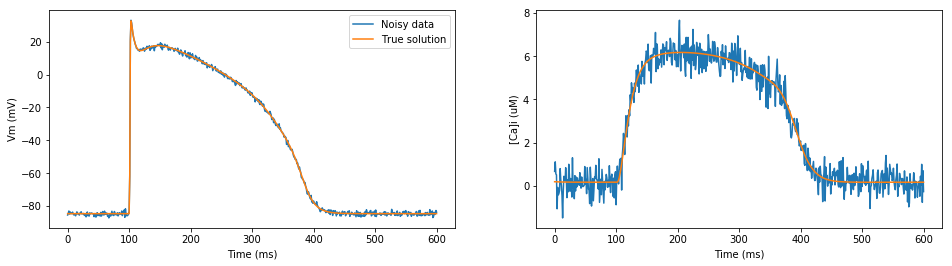

In [3]:
# Create a model
model = APCaTModel()

# Generate some 'experimental' data
x_true = np.array([4, 0.003, 0.09, 0.35, 0.8])
times = np.linspace(0, 600, 601)
values = model.simulate(x_true, times)

# Add noise
noisy_values = np.array(values, copy=True)
noisy_values[:, 0] += np.random.normal(0, 1, values[:, 0].shape)
noisy_values[:, 1] += np.random.normal(0, 5e-7, values[:, 1].shape)

# Show the initial data
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Vm (mV)')
ax.plot(times, noisy_values[:, 0], label='Noisy data')
ax.plot(times, values[:, 0], label='True solution')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('[Ca]i (uM)')
ax.plot(times, noisy_values[:, 1] * 1e6)
ax.plot(times, values[:, 1] * 1e6) # Convert to micromolar

plt.show()

And again we set up an optimisation problem, but this time we use a MultiOutputProblem.
Because the AP and CaT have very different scales, we also define weighting to use when calculating the goodness of fit:

In [4]:
# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, noisy_values)

# Create a score function
weights = [1 / 70, 1 / 0.000006]
score = pints.SumOfSquaresError(problem, weights=weights)

# Select some boundaries
lower = x_true / 5
upper = x_true * 5
boundaries = pints.RectangularBoundaries(lower, upper)

# Perform an optimization
x0 = x_true * 2**np.random.normal(0, 1, x_true.shape)
optimiser = pints.OptimisationController(
    score, x0, boundaries=boundaries, method=pints.CMAES)

print('Running...')
x_found, score_found = optimiser.run()

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(x_found):
    print(pints.strfloat(x) + '    ' + pints.strfloat(x_true[k]))

Running...
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Time m:s
0     8      4404.403   0:00.2
1     16     4202.058   0:00.2
2     24     3308.951   0:00.2
3     32     2070.396   0:00.3
20    168    37.30053   0:00.9
40    328    32.38264   0:01.7
60    488    32.11463   0:02.5
80    648    31.64049   0:03.2
100   808    20.85263   0:03.9
120   968    9.997103   0:04.7
140   1128   8.567112   0:05.4
160   1288   8.376414   0:06.3
180   1448   8.371698   0:07.0
200   1608   8.369944   0:07.8
220   1768   8.369936   0:08.6
240   1928   8.369835   0:09.4
260   2088   8.369593   0:10.2
280   2248   8.369593   0:10.9
300   2408   8.369512   0:11.6
320   2568   8.369425   0:12.4
340   2728   8.369413   0:13.1
360   2888   8.369413   0:13.8
380   3048   8.369413   0:14.6
400   3208   8.369413   0:15.3
420   3368   8.369413   0:16.1
440   3528   8.369413   0:16.9
460   3688   8.36

Finally, we inspect the results:

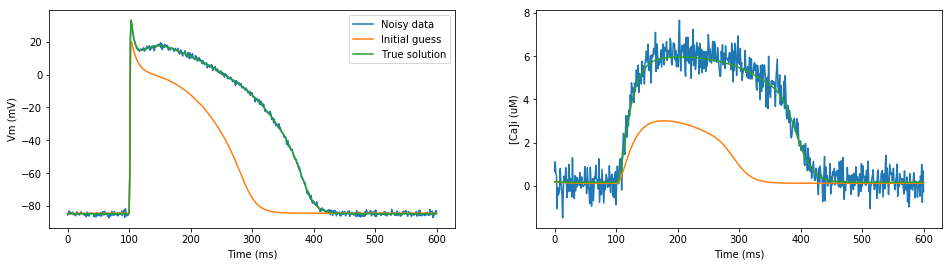

In [5]:
initial = problem.evaluate(x0)
fitted = problem.evaluate(x_found)

# Create figure
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Vm (mV)')
ax.plot(times, noisy_values[:, 0], label='Noisy data')
ax.plot(times, initial[:, 0], label='Initial guess')
ax.plot(times, fitted[:, 0], label='True solution')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('[Ca]i (uM)')
ax.plot(times, noisy_values[:, 1] * 1e6)
ax.plot(times, initial[:, 1] * 1e6) # Convert to micromolar
ax.plot(times, fitted[:, 1] * 1e6) # Convert to micromolar

plt.show()

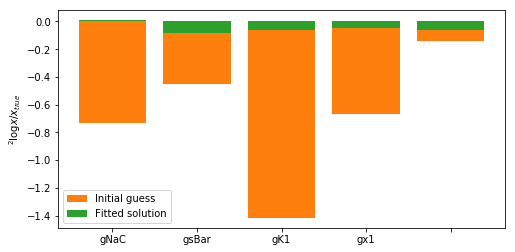

In [6]:
fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot(1, 1, 1)
p = ['gNaBar', 'gNaC', 'gsBar', 'gK1', 'gx1']
ax.set_xticklabels(p)
ax.set_ylabel('$^2\log x / x_{true} $')

x = np.arange(1, 1 + len(p))
ax.bar(x, 0 * x)
ax.bar(x, np.log2(x0 / x_true), label='Initial guess')
ax.bar(x, np.log2(x_found / x_true), label='Fitted solution')
ax.legend()

plt.show()

## Summary

In this tutorial, we extended the AP fitting example to simultaneously fit an AP and CaT.